In [1]:
import os
os.chdir('../')

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
data_path = "/data2/wlsgur4011/SparseDC/datas/cache/1.marigold(vanilla)_a8b9d00ddfebe9d72ec8a22fdb190230.pt"
data = torch.load(data_path)
import jhutil; jhutil.jhprint(1111, data)

1111  {
    "name": "1.marigold(vanilla)",
    "image": "<PIL.Image.Image image mode=RGB size=304x228 at 0x7FBB904379D0>",
    "depth_pred": "tensor[228, 304] n=69312 (0.3Mb) x∈[0.002, 1.000] μ=0.240 σ=0.264 cuda:0",
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 1.000] μ=0.535 σ=0.303 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 6.848] μ=0.013 σ=0.201 cuda:0",
    "gt": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.000, 7.159] μ=2.408 σ=1.605 cuda:0"
}


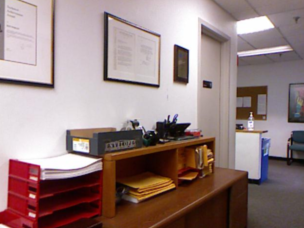

In [4]:
data["image"]

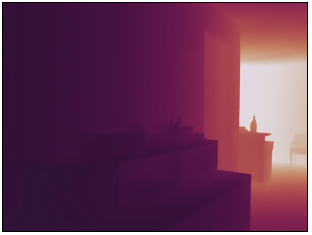

In [5]:
data["depth_pred"].chans

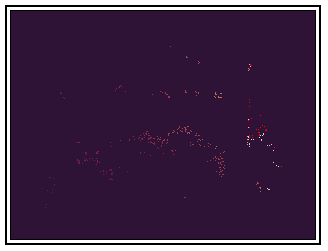

In [6]:
(data["dep"] / 5).chans

In [7]:
data

{'name': '1.marigold(vanilla)',
 'image': <PIL.Image.Image image mode=RGB size=304x228>,
 'depth_pred': tensor[228, 304] n=69312 (0.3Mb) x∈[0.002, 1.000] μ=0.240 σ=0.264 cuda:0,
 'rgb': tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 1.000] μ=0.535 σ=0.303 cuda:0,
 'dep': tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 6.848] μ=0.013 σ=0.201 cuda:0,
 'gt': tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.000, 7.159] μ=2.408 σ=1.605 cuda:0}

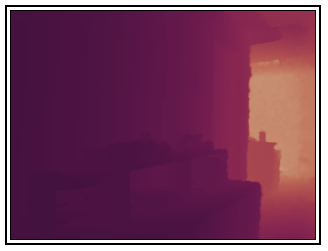

In [8]:
(data["gt"] / 10).chans

In [9]:
sam = None

In [19]:
from src.utils.depth_utils import get_depth_affine, get_depth_dbscan, get_depth_sam
from src.utils.depth_utils import *

clusters = None

def get_depth_sam(rgb, depth_estim, depth_gt_sparse):
    global sam, clusters
    if sam is None:
        sam_checkpoint = "/data2/wlsgur4011/SparseDC/pretrain/sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        model.to(device="cuda")
        sam = SamAutomaticMaskGenerator(model)
    clusters = sam.generate(rgb)

    if depth_estim.ndim == 3:
        depth_estim = depth_estim.squeeze(0)
    if depth_gt_sparse.ndim == 3:
        depth_gt_sparse = depth_gt_sparse.squeeze(0)

    new_depth = torch.zeros_like(depth_estim)

    for i, cluster in enumerate(clusters):
        cluster = torch.tensor(cluster['segmentation']).cuda()
        cluster_depth = cluster * depth_gt_sparse
        if cluster_depth.sum() < 3:
            continue

        mask = cluster_depth != 0
        scale, shift = compute_scale_and_shift(depth_estim[None, :], depth_gt_sparse[None, :], mask[None, :])
        err = ((scale * depth_estim + shift) - depth_gt_sparse)[mask].abs().mean()
        # if err > 0.03:
        #     continue
        
        import jhutil; jhutil.jhprint(1111, cluster.sum())
        new_depth[cluster] = scale * depth_estim[cluster] + shift
        

    mask = depth_gt_sparse != 0
    # scale, shift = compute_scale_and_shift(depth_estim[None, :], depth_gt_sparse[None, :], mask[None, :])
    # scaled_depth = scale * depth_estim + shift

    mask = new_depth == 0
    # new_depth[mask] = scaled_depth[mask]

    sam_mask = ~mask

    return new_depth, sam_mask

rgb = np.array(data["image"])
depth_estim  = data["depth_pred"]
depth_gt_sparse = data["dep"][0][0]

new_depth, sam_mask = get_depth_sam(rgb, depth_estim, depth_gt_sparse)

1111  "tensor i64 cuda:0 5594"
1111  "tensor i64 cuda:0 4485"
1111  "tensor i64 cuda:0 3356"
1111  "tensor i64 cuda:0 19149"
1111  "tensor i64 cuda:0 1319"
1111  "tensor i64 cuda:0 959"
1111  "tensor i64 cuda:0 3183"
1111  "tensor i64 cuda:0 521"
1111  "tensor i64 cuda:0 3042"
1111  "tensor i64 cuda:0 1707"
1111  "tensor i64 cuda:0 65"
1111  "tensor i64 cuda:0 8515"
1111  "tensor i64 cuda:0 239"
1111  "tensor i64 cuda:0 782"
1111  "tensor i64 cuda:0 335"
1111  "tensor i64 cuda:0 3375"
1111  "tensor i64 cuda:0 1184"
1111  "tensor i64 cuda:0 271"
1111  "tensor i64 cuda:0 42"
1111  "tensor i64 cuda:0 5002"
1111  "tensor i64 cuda:0 533"
1111  "tensor i64 cuda:0 103"
1111  "tensor i64 cuda:0 1104"
1111  "tensor i64 cuda:0 807"
1111  "tensor i64 cuda:0 8551"
1111  "tensor i64 cuda:0 331"
1111  "tensor i64 cuda:0 291"
1111  "tensor i64 cuda:0 1009"
1111  "tensor i64 cuda:0 6364"
1111  "tensor i64 cuda:0 187"
1111  "tensor i64 cuda:0 503"
1111  "tensor i64 cuda:0 147"
1111  "tensor i64 cuda:0 

In [20]:
clusters

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 5594,
  'bbox': [96, 168, 151, 59],
  'predicted_iou': 1.0336308479309082,
  'point_coords': [[232.75, 203.0625]],
  'stability_score': 0.9683842658996582,
  'crop_box': [0, 0, 304, 228]},
 {'segmentation': array([[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 269,
  'bbox': [0, 0, 4, 58],
 

In [21]:
clusters = iter(clusters)

In [22]:
total_seg = None

for cluster in clusters:
    seg = torch.tensor(cluster['segmentation']).float()
    if total_seg is None:
        total_seg = torch.zeros_like(seg)
    total_seg += seg

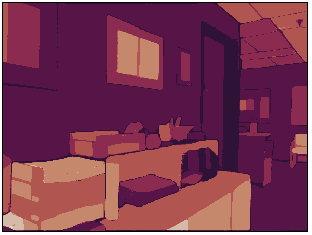

In [23]:
(total_seg.float() / 6).chans

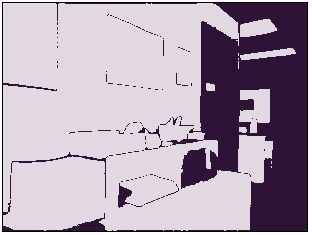

In [24]:
# 흰색을 보면 됨. 
sam_mask.chans

In [25]:
sam_mask.sum()

tensor i64 cuda:0 49627

In [26]:

def compare_sam_and_affine(data):
    rgb = np.array(data["image"])
    depth_gt_sparse = data["dep"][0][0]
    depth_estim = data["depth_pred"]
    mask_sparse = depth_gt_sparse != 0
    
    depth_sam, sam_mask = get_depth_sam(rgb, depth_estim, depth_gt_sparse)
    depth_affine = get_depth_affine(depth_estim, depth_gt_sparse)
    
    depth_gt = data["gt"][0][0]
    diff_sam = depth_sam - depth_gt
    diff_affine = depth_affine - depth_gt
    
    return diff_sam * sam_mask, diff_affine * sam_mask, sam_mask

In [27]:
diff_sam, diff_affine, sam_mask = compare_sam_and_affine(data)
import jhutil; jhutil.jhprint(1111, "ERR sam", diff_sam.abs().mean())
import jhutil; jhutil.jhprint(2222, "ERR affine", diff_affine.abs().mean())

1111  "tensor i64 cuda:0 5594"
1111  "tensor i64 cuda:0 4485"
1111  "tensor i64 cuda:0 3356"
1111  "tensor i64 cuda:0 19149"
1111  "tensor i64 cuda:0 1319"
1111  "tensor i64 cuda:0 959"
1111  "tensor i64 cuda:0 3183"
1111  "tensor i64 cuda:0 521"
1111  "tensor i64 cuda:0 3042"
1111  "tensor i64 cuda:0 1707"
1111  "tensor i64 cuda:0 65"
1111  "tensor i64 cuda:0 8515"
1111  "tensor i64 cuda:0 239"
1111  "tensor i64 cuda:0 782"
1111  "tensor i64 cuda:0 335"
1111  "tensor i64 cuda:0 3375"
1111  "tensor i64 cuda:0 1184"
1111  "tensor i64 cuda:0 271"
1111  "tensor i64 cuda:0 42"
1111  "tensor i64 cuda:0 5002"
1111  "tensor i64 cuda:0 533"
1111  "tensor i64 cuda:0 103"
1111  "tensor i64 cuda:0 1104"
1111  "tensor i64 cuda:0 807"
1111  "tensor i64 cuda:0 8551"
1111  "tensor i64 cuda:0 331"
1111  "tensor i64 cuda:0 291"
1111  "tensor i64 cuda:0 1009"
1111  "tensor i64 cuda:0 6364"
1111  "tensor i64 cuda:0 187"
1111  "tensor i64 cuda:0 503"
1111  "tensor i64 cuda:0 147"
1111  "tensor i64 cuda:0 

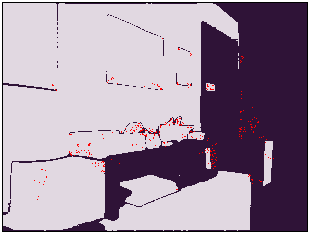

In [26]:
(sam_mask + data["dep"][0][0]).chans

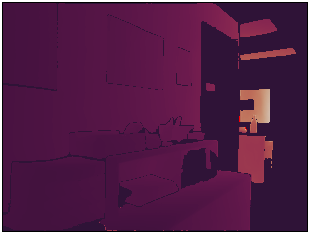

In [28]:
(new_depth / 10).chans

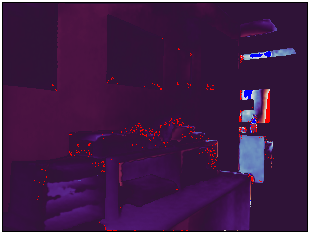

In [29]:
(diff_sam + data["dep"][0][0]).chans

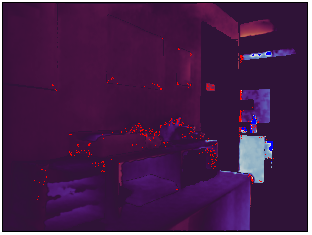

In [30]:
(diff_affine + data["dep"][0][0]).chans

In [39]:
import numpy as np
data_folder = "/data2/wlsgur4011/SparseDC/datas/cache"

err_dbscan_list = []
err_affine_list = []

data_path_iter = iter(os.listdir(data_folder))


In [66]:
while True:    
    data_path = next(data_path_iter)
    data = torch.load(os.path.join(data_folder, data_path))
    diff_sam, diff_affine = compare_dbscan_and_affine(data)
    err_dbscan = diff_sam.abs().mean().cpu().numpy()
    err_affine = diff_affine.abs().mean().cpu().numpy()
    # err_dbscan_list.append(err_dbscan)
    # err_affine_list.append(err_affine)
    if err_affine < err_dbscan / 2:
        break

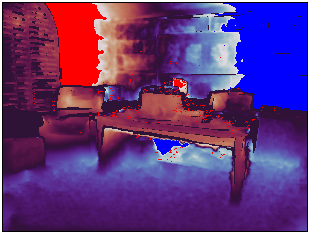

In [67]:
(diff_sam + data["dep"][0][0] * 100).chans

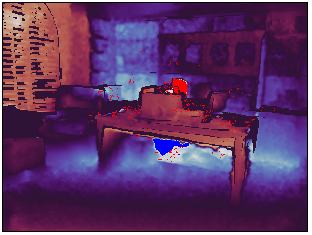

In [68]:
(diff_affine + data["dep"][0][0]).chans

In [23]:
import jhutil; jhutil.jhprint(1111, np.mean(err_dbscan_list))
import jhutil; jhutil.jhprint(2222, np.mean(err_affine_list))

1111  "0.23241523"
2222  "0.24943827"


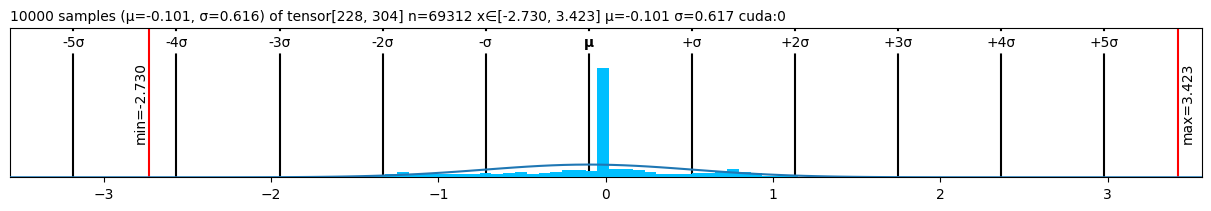

In [30]:
diff_affine.plt